In [4]:
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.74",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = ParityMapper()
qubit_op = mapper.map(molecule.hamiltonian.second_q_op())
print(qubit_op)
cost_h=qubit_op


from qiskit.quantum_info import SparsePauliOp

driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0),
    ("IXII", -1.0),
    ("IIXI", -1.0),
    ("IIIX", -1.0),
])
print(driver_h)

from qiskit.quantum_info import SparsePauliOp

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)
print(comm_h)


SparsePauliOp(['IIII', 'IIIZ', 'IIZZ', 'IZZI', 'ZZII', 'IIZI', 'IZZZ', 'ZZIZ', 'ZXIX', 'IXZX', 'ZXZX', 'IXIX', 'IZIZ', 'ZZZZ', 'ZIZI'],
              coeffs=[-0.81217061+0.j,  0.17141283+0.j, -0.22343154+0.j,  0.17141283+0.j,
 -0.22343154+0.j,  0.12062523+0.j,  0.16868898+0.j,  0.16592785+0.j,
  0.04530262+0.j, -0.04530262+0.j, -0.04530262+0.j,  0.04530262+0.j,
  0.16592785+0.j,  0.17441288+0.j,  0.12062523+0.j])
SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
SparsePauliOp(['YZII', 'YZIZ', 'YXIX', 'YXZX', 'YZZZ', 'YIZI', 'IYZI', 'ZYII', 'IYZZ', 'ZYIZ', 'IYIZ', 'ZYZZ', 'IIYZ', 'IZYI', 'IIYI', 'IZYZ', 'IXYX', 'ZXYX', 'ZZYZ', 'ZIYI', 'IIIY', 'IIZY', 'IZZY', 'ZZIY', 'IZIY', 'ZZZY'],
              coeffs=[ 0.44686307+0.j, -0.3318557 +0.j, -0.09060523+0.j,  0.09060523+0.j,
 -0.34882575+0.j, -0.24125047+0.j, -0.34282565+0.j,  0.44686307+0.j,
 -0.33737796+0.j, -0.3318557 +0.j, -0.3318557 +0.j, -0.34882575+0.j,
  0.44686307+0.j, -0.342

In [5]:
from qiskit.circuit import QuantumCircuit
from numpy import pi

def apply_pauli_evolution(qc, pauli_str, angle):
    n = qc.num_qubits
    pauli_str = pauli_str[::-1]  # reverse Qiskit convention
    indices = [i for i, p in enumerate(pauli_str) if p != 'I']
    if not indices:
        return

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.sdg(i)
            qc.h(i)

    if len(indices) > 1:
        for i in range(len(indices) - 1):
            qc.cx(indices[i], indices[i+1])
        target = indices[-1]
    else:
        target = indices[0]

    qc.rz(2 * angle, target)

    if len(indices) > 1:
        for i in reversed(range(len(indices) - 1)):
            qc.cx(indices[i], indices[i+1])

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.h(i)
            qc.s(i)

def apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t):
    for label, coeff in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * delta_t))
    for label, coeff in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * beta_k * delta_t))


from qiskit.quantum_info import Statevector

from qiskit import transpile

def build_statevector(beta_list, cost_h, driver_h, delta_t, n_qubits, basis_gates=None):
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.h(i)

    for beta_k in beta_list:
        apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t)

    if basis_gates is not None:
        qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

    state = Statevector.from_instruction(qc)
    return state, qc

from collections import Counter

def falqon_qiskit(n_qubits, n_layers, beta_1, delta_t, cost_h, driver_h, comm_h, basis_gates=None):


    beta = [beta_1]
    energies = []
    total_gate_counts = Counter()

    for i in range(n_layers):
        state, qc = build_statevector(beta, cost_h, driver_h, delta_t, n_qubits, basis_gates)
        
        # 累加门计数
        total_gate_counts += Counter(qc.count_ops())

        energy = state.expectation_value(cost_h).real
        next_beta = -1 * delta_t * state.expectation_value(comm_h).real

        beta.append(next_beta)
        energies.append(energy)
        print(f"第{i+1}步：能量 = {energy:.6f} Ha")

    return beta, energies, total_gate_counts



import matplotlib.pyplot as plt

n_qubits = 4
n = 300
beta_1 = 0.0
delta_t = 0.03
basis = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']

 # 例如超导平台的标准 gate set

res_beta, res_energies, total_gate_counts = falqon_qiskit(
    n_qubits=n_qubits,
    n_layers=n,
    beta_1=beta_1,
    delta_t=delta_t,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    basis_gates=basis
)


# 输出门统计
print("\n📊 迭代全过程中总基础门统计：")
for gate, count in total_gate_counts.items():
    print(f"{gate}: {count}")

# 绘图
plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON via Qiskit")
plt.show()



第1步：能量 = -0.766843 Ha
第2步：能量 = -0.766828 Ha
第3步：能量 = -0.766836 Ha
第4步：能量 = -0.766877 Ha
第5步：能量 = -0.766961 Ha
第6步：能量 = -0.767100 Ha
第7步：能量 = -0.767303 Ha
第8步：能量 = -0.767581 Ha
第9步：能量 = -0.767944 Ha
第10步：能量 = -0.768400 Ha
第11步：能量 = -0.768958 Ha
第12步：能量 = -0.769628 Ha
第13步：能量 = -0.770416 Ha
第14步：能量 = -0.771331 Ha
第15步：能量 = -0.772378 Ha
第16步：能量 = -0.773565 Ha
第17步：能量 = -0.774896 Ha
第18步：能量 = -0.776376 Ha
第19步：能量 = -0.778009 Ha
第20步：能量 = -0.779799 Ha
第21步：能量 = -0.781748 Ha
第22步：能量 = -0.783858 Ha
第23步：能量 = -0.786129 Ha
第24步：能量 = -0.788563 Ha
第25步：能量 = -0.791158 Ha
第26步：能量 = -0.793913 Ha
第27步：能量 = -0.796827 Ha
第28步：能量 = -0.799895 Ha
第29步：能量 = -0.803114 Ha
第30步：能量 = -0.806480 Ha
第31步：能量 = -0.809988 Ha
第32步：能量 = -0.813631 Ha
第33步：能量 = -0.817404 Ha
第34步：能量 = -0.821300 Ha
第35步：能量 = -0.825310 Ha
第36步：能量 = -0.829427 Ha
第37步：能量 = -0.833643 Ha
第38步：能量 = -0.837947 Ha
第39步：能量 = -0.842331 Ha
第40步：能量 = -0.846786 Ha
第41步：能量 = -0.851301 Ha
第42步：能量 = -0.855866 Ha
第43步：能量 = -0.860471 Ha
第44步：能量 = -0.865107 

KeyboardInterrupt: 

第1步：能量 = -0.766843 Ha
第2步：能量 = -0.766828 Ha
第3步：能量 = -0.766836 Ha
第4步：能量 = -0.766877 Ha
第5步：能量 = -0.766961 Ha
第6步：能量 = -0.767100 Ha
第7步：能量 = -0.767303 Ha
第8步：能量 = -0.767581 Ha
第9步：能量 = -0.767944 Ha
第10步：能量 = -0.768400 Ha
第11步：能量 = -0.768958 Ha
第12步：能量 = -0.769628 Ha
第13步：能量 = -0.770416 Ha
第14步：能量 = -0.771331 Ha
第15步：能量 = -0.772378 Ha
第16步：能量 = -0.773565 Ha
第17步：能量 = -0.774896 Ha
第18步：能量 = -0.776376 Ha
第19步：能量 = -0.778009 Ha
第20步：能量 = -0.779799 Ha
第21步：能量 = -0.781748 Ha
第22步：能量 = -0.783858 Ha
第23步：能量 = -0.786129 Ha
第24步：能量 = -0.788563 Ha
第25步：能量 = -0.791158 Ha
第26步：能量 = -0.793913 Ha
第27步：能量 = -0.796827 Ha
第28步：能量 = -0.799895 Ha
第29步：能量 = -0.803114 Ha
第30步：能量 = -0.806480 Ha
第31步：能量 = -0.809988 Ha
第32步：能量 = -0.813631 Ha
第33步：能量 = -0.817404 Ha
第34步：能量 = -0.821300 Ha
第35步：能量 = -0.825310 Ha
第36步：能量 = -0.829427 Ha
第37步：能量 = -0.833643 Ha
第38步：能量 = -0.837947 Ha
第39步：能量 = -0.842331 Ha
第40步：能量 = -0.846786 Ha
第41步：能量 = -0.851301 Ha
第42步：能量 = -0.855866 Ha
第43步：能量 = -0.860471 Ha
第44步：能量 = -0.865107 

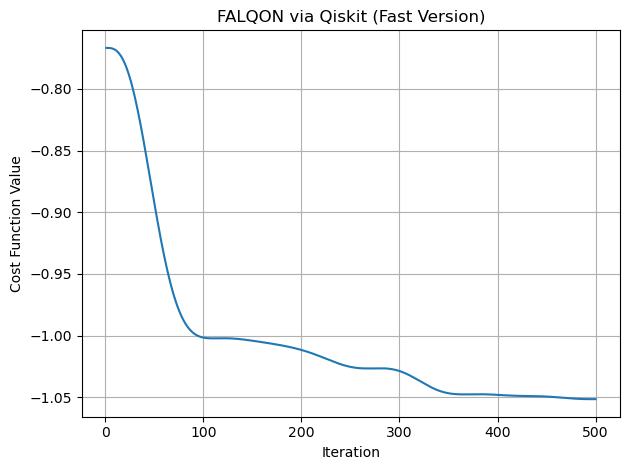

In [11]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit import QuantumCircuit
from numpy import pi
from collections import Counter
import matplotlib.pyplot as plt

# ----------- Pauli Gate 演化 -------------
def apply_pauli_evolution(qc, pauli_str, angle):
    n = qc.num_qubits
    pauli_str = pauli_str[::-1]  # Qiskit 是 little-endian
    indices = [i for i, p in enumerate(pauli_str) if p != 'I']
    if not indices:
        return

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.sdg(i)
            qc.h(i)

    if len(indices) > 1:
        for i in range(len(indices) - 1):
            qc.cx(indices[i], indices[i + 1])
        target = indices[-1]
    else:
        target = indices[0]

    qc.rz(2 * angle, target)

    if len(indices) > 1:
        for i in reversed(range(len(indices) - 1)):
            qc.cx(indices[i], indices[i + 1])

    for i in indices:
        if pauli_str[i] == 'X':
            qc.h(i)
        elif pauli_str[i] == 'Y':
            qc.h(i)
            qc.s(i)


# ----------- 单层 FALQON 结构 -------------
def apply_falqon_layer(qc, beta_k, cost_h, driver_h, delta_t):
    for label, coeff in zip(cost_h.paulis.to_labels(), cost_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * delta_t))
    for label, coeff in zip(driver_h.paulis.to_labels(), driver_h.coeffs):
        apply_pauli_evolution(qc, label, float(coeff.real * beta_k * delta_t))

from qiskit import transpile

def falqon_qiskit_fast(n_qubits, n_layers, beta_1, delta_t, cost_h, driver_h, comm_h, basis_gates=None):
    beta = [beta_1]
    energies = []
    total_gate_counts = Counter()

    state = Statevector.from_label("+" * n_qubits)  # 初始全Hadamard态
    qc_layer = QuantumCircuit(n_qubits)

    for i in range(n_layers):
        qc_layer.data.clear()
        apply_falqon_layer(qc_layer, beta[i], cost_h, driver_h, delta_t)

        # ✅ 限制基础门集合（如 ['rz', 'rx', 'cx']），适配不同平台
        if basis_gates is not None:
            qc_layer = transpile(qc_layer, basis_gates=basis_gates, optimization_level=1)

        # ✅ 记录统计门数（是 transpile 后的结果）
        total_gate_counts += Counter(qc_layer.count_ops())

        # ✅ 演化状态向量
        state = state.evolve(qc_layer)

        # ✅ 能量和反馈更新
        energy = state.expectation_value(cost_h).real
        next_beta = -delta_t * state.expectation_value(comm_h).real

        energies.append(energy)
        beta.append(next_beta)

        print(f"第{i + 1}步：能量 = {energy:.6f} Ha")

    return beta, energies, total_gate_counts

# ====================================



basis = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']
n_layers = 500
beta_1 = 0.0
delta_t = 0.03
res_beta, res_energies, total_gate_counts = falqon_qiskit_fast(
    n_qubits=4,
    n_layers=n_layers,
    beta_1=beta_1,
    delta_t=delta_t,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    basis_gates=basis
)

# ----------- 输出门统计与绘图 -------------
print("\n📊 迭代全过程中总基础门统计：")
for gate, count in total_gate_counts.items():
    print(f"{gate}: {count}")

plt.plot(range(1, n_layers + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON via Qiskit (Fast Version)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
def falqon_qiskit_fast_final_gate_count(n_qubits, n_layers, beta_1, delta_t, cost_h, driver_h, comm_h):
    beta = [beta_1]
    energies = []

    state = Statevector.from_label("+" * n_qubits)
    final_circuit = QuantumCircuit(n_qubits)
    final_circuit.h(range(n_qubits))  # 初始 H^{⊗n}

    for i in range(n_layers):
        qc_layer = QuantumCircuit(n_qubits)
        apply_falqon_layer(qc_layer, beta[i], cost_h, driver_h, delta_t)

        # 记录门：拼接进最终电路
        final_circuit.compose(qc_layer, inplace=True)

        # 更新状态向量
        state = state.evolve(qc_layer)

        # 反馈更新
        energy = state.expectation_value(cost_h).real
        next_beta = -delta_t * state.expectation_value(comm_h).real

        energies.append(energy)
        beta.append(next_beta)

        print(f"第{i + 1}步：能量 = {energy:.6f} Ha")

    return beta, energies, final_circuit

from qiskit import transpile

# 基础门集合（例如 IBM 超导平台）

# 执行主算法
basis = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']
n_layers = 20000
beta_1 = 0.0
delta_t = 0.03
res_beta, res_energies, total_gate_counts = falqon_qiskit_fast_final_gate_count(
    n_qubits=4,
    n_layers=n_layers,
    beta_1=beta_1,
    delta_t=delta_t,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h
)


# ✅ 最后统一 transpile 并统计基础门数量
transpiled_circuit = transpile(final_circuit, basis_gates=basis, optimization_level=1)
final_gate_counts = transpiled_circuit.count_ops()

# ✅ 打印统计
print("\n📊 最终电路在指定基础门集下的门数量统计：")
for gate, count in final_gate_counts.items():
    print(f"{gate}: {count}")




第1步：能量 = -0.766843 Ha
第2步：能量 = -0.766828 Ha
第3步：能量 = -0.766836 Ha
第4步：能量 = -0.766877 Ha
第5步：能量 = -0.766961 Ha
第6步：能量 = -0.767100 Ha
第7步：能量 = -0.767303 Ha
第8步：能量 = -0.767581 Ha
第9步：能量 = -0.767944 Ha
第10步：能量 = -0.768400 Ha
第11步：能量 = -0.768958 Ha
第12步：能量 = -0.769628 Ha
第13步：能量 = -0.770416 Ha
第14步：能量 = -0.771331 Ha
第15步：能量 = -0.772378 Ha
第16步：能量 = -0.773565 Ha
第17步：能量 = -0.774896 Ha
第18步：能量 = -0.776376 Ha
第19步：能量 = -0.778009 Ha
第20步：能量 = -0.779799 Ha
第21步：能量 = -0.781748 Ha
第22步：能量 = -0.783858 Ha
第23步：能量 = -0.786129 Ha
第24步：能量 = -0.788563 Ha
第25步：能量 = -0.791158 Ha
第26步：能量 = -0.793913 Ha
第27步：能量 = -0.796827 Ha
第28步：能量 = -0.799895 Ha
第29步：能量 = -0.803114 Ha
第30步：能量 = -0.806480 Ha
第31步：能量 = -0.809988 Ha
第32步：能量 = -0.813631 Ha
第33步：能量 = -0.817404 Ha
第34步：能量 = -0.821300 Ha
第35步：能量 = -0.825310 Ha
第36步：能量 = -0.829427 Ha
第37步：能量 = -0.833643 Ha
第38步：能量 = -0.837947 Ha
第39步：能量 = -0.842331 Ha
第40步：能量 = -0.846786 Ha
第41步：能量 = -0.851301 Ha
第42步：能量 = -0.855866 Ha
第43步：能量 = -0.860471 Ha
第44步：能量 = -0.865107 